In [1]:
%load_ext autoreload
%autoreload 2
%run A_simple_net.ipynb

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.


Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

numpy     : 1.19.2
matplotlib: 3.3.2
pyNN      : 0.9.5
neo       : 0.8.0
nixio     : 1.5.0b6
pandas    : 0.25.3

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-56-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: inv-ope-de06

Git hash: 19c9ce9dd5fc286086d33adb94a47085bdca80f0

Git repo: https://github.com/SpikeAI/2020-11_brainhack_Project7

Git branch: main



In [2]:
%mkdir -p outputs

In [3]:
%mkdir -p Results/20201204/

# scanning over single parameters

## initializing parameters

In [4]:
date = '2020-12-04_nixio'
tag = date + '_scan_' + simulator

In [5]:
buildCPUTime, simCPUTime, writeCPUTime = run(verbose=True)

/usr/lib/python3.8/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.
2020-12-04 16:29:29,762 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:29:29,764 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


0 Creating cell populations...
0 Initialising membrane potential to random values...
0 Connecting populations...
0 Setting up recording...0%                                                                                                                                                                                                                                                                                                                                                                        
0 Running simulation...
0 Writing data to file...

--- Vogels-Abbott Network Simulation ---
Nodes                  : 1
Number of Neurons      : 1000
Excitatory conductance : 4 nS
Inhibitory conductance : 51 nS
Excitatory rate        : 0.715 Hz
Inhibitory rate        : 0.73 Hz
Build time             : 2832.21 ms
Simulation time        : 2310.05 ms
Writing time           : 178.419 ms


## Running Model and Loading Results

In [6]:
import os
import pandas as pd
verbose = True
def scan(variable, values, tag=tag, verbose=verbose):
    filename = f'outputs/{tag}_{variable}.json'
    try:
        df = pd.read_json(filename)
        print('Loaded file')
    except:
        df = pd.DataFrame([], columns=[variable, 'buildCPUTime', 'simCPUTime', 'writeCPUTime'])
        for i, value in enumerate(values):
            if verbose: print(f'{variable=}---{value=}')
            args = {'do_nixio': True}
            args[variable] = value
            buildCPUTime, simCPUTime, writeCPUTime = run(**args)
            df.loc[i]= {variable: value, 'buildCPUTime':buildCPUTime, 'simCPUTime':simCPUTime, 'writeCPUTime':writeCPUTime}
        df.to_json(filename)
    return df

In [7]:
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression
def plot(df, do_intercept=False):
    variable = df.columns[0]
    fig, ax = plt.subplots(figsize=(8,8))
    
    for regressor, color in zip(['buildCPUTime', 'simCPUTime', 'writeCPUTime'],
                                ['r', 'g', 'b']):

        import patsy
        if do_intercept:
            y, X = patsy.dmatrices(f'{regressor} ~ {variable}', data=df, return_type='dataframe')
        else:
            y, X = patsy.dmatrices(f'{regressor} ~ 0 + {variable}', data=df, return_type='dataframe')

        import statsmodels.api as sm
        fit = sm.OLS(y, X).fit()
        print(fit.summary())

        if do_intercept: intercept = fit.params.Intercept
        slope = fit.params[variable]

        values = np.array(df[variable])
        if do_intercept:
            ax.plot(values, intercept + slope*values, c=color, lw=1)
            df.plot(x=variable, y=regressor, c=color, lw=2, ls='-.', ax=ax, label=f"{regressor}={intercept:.3f} + {slope:.3f}*{variable}")
        else:
            ax.plot(values, slope*values, c=color, lw=1)
            df.plot(x=variable, y=regressor, c=color, lw=2, ls='-.', ax=ax, label=f"{regressor}={slope:.3f}*{variable}")

    ax.set_xlim(0)
    ax.set_ylabel('Time (ms)')
    ax.set_ylim(0)
    ax.legend()
    return fig, ax

## plot as a function of neuron numbers

In [8]:
import numpy as np
N_pops = np.array([int(k)**2 for k in np.linspace(8**2, 45**2, 14, endpoint=True)**.5])
N_pops

array([  64,  196,  361,  484,  625,  784,  961, 1089, 1225, 1369, 1521,
       1681, 1849, 2025])

In [9]:
results_pop = scan('N_pop', N_pops)

Loaded file


/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14


                                 OLS Regression Results                                
Dep. Variable:           buildCPUTime   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              7633.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):                    2.16e-19
Time:                        16:29:35   Log-Likelihood:                         -64.149
No. Observations:                  14   AIC:                                      130.3
Df Residuals:                      13   BIC:                                      130.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

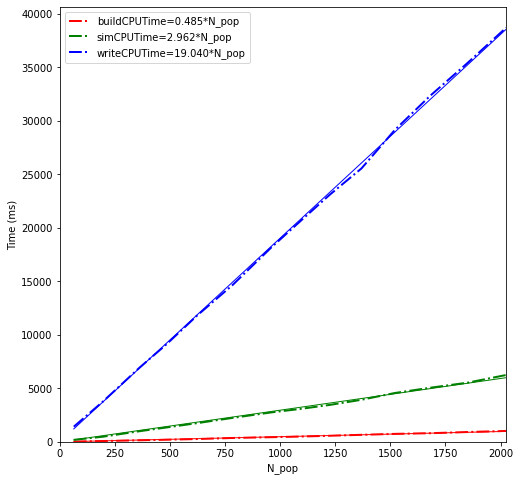

In [10]:
fig, ax = plot(results_pop)

In [11]:
fig.savefig(tag + '_N_pop.png')

## plot as a function of simtime

In [12]:
simtimes = np.linspace(500, 3000, 15, endpoint=True)
simtimes

array([ 500.        ,  678.57142857,  857.14285714, 1035.71428571,
       1214.28571429, 1392.85714286, 1571.42857143, 1750.        ,
       1928.57142857, 2107.14285714, 2285.71428571, 2464.28571429,
       2642.85714286, 2821.42857143, 3000.        ])

In [13]:
results_simtime = scan('simtime', simtimes)

Loaded file


                            OLS Regression Results                            
Dep. Variable:           buildCPUTime   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     4.691
Date:                Fri, 04 Dec 2020   Prob (F-statistic):             0.0495
Time:                        16:29:35   Log-Likelihood:                -52.543
No. Observations:                  15   AIC:                             109.1
Df Residuals:                      13   BIC:                             110.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    467.0882      5.525     84.540      0.0

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15


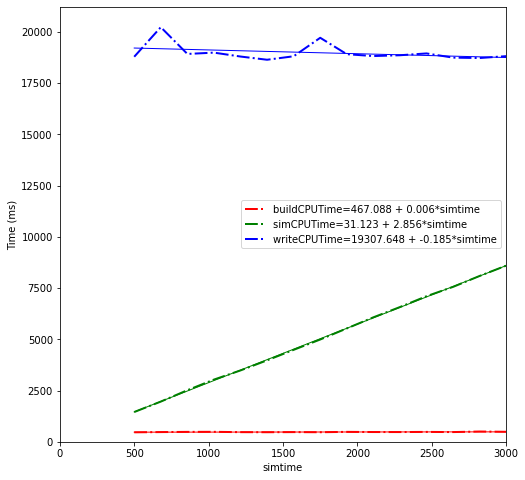

In [14]:
fig, ax = plot(results_simtime, do_intercept=True)      

In [15]:
fig.savefig(tag + '_simtime.png')

# scanning over two parameters

## Setting-up model and initializing parameters

In [16]:
tag = date + '_scan-2D_' + simulator

## Running Model and Loading Results

In [17]:
variables = ['N_pop', 'simtime']
filename = f'outputs/{tag}'
for variable in variables: filename +=  '_' + variable
filename += '.json'

In [18]:
import os
import time
import pandas as pd
verbose = True
def scan(variables, values, tag=tag, verbose=verbose):
    filename = f'outputs/{tag}'
    for variable in variables: filename +=  '_' + variable
    filename += '.json'
    try:
        df = pd.read_json(filename)
        print('Loaded file')
    except:
        df = pd.DataFrame([], columns=variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime'])
        for i, values_ in enumerate(values):
            if verbose: print(f'{variable=}---{values_=}')
            args = {'do_nixio': True}
            for variable, value in zip(variables, values_):
                args[variable] = value
            buildCPUTime, simCPUTime, writeCPUTime = run(**args)
            df.loc[i]= dict(zip(variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime'], 
                                list(values_) + [buildCPUTime, simCPUTime, writeCPUTime]))

        df.to_json(filename)
        
    return df

## Running time as a function of neuron numbers and simtime

In [19]:
import numpy as np

In [20]:
N_trials = 200
N_pops = [int(k)**2 for k in np.linspace(15, 60, N_trials, endpoint=True)]
simtimes = np.linspace(200, 3000, N_trials, endpoint=True)

In [21]:
np.random.seed(42)
np.random.shuffle(N_pops)
np.random.shuffle(simtimes)
values = zip(N_pops, simtimes)

In [ ]:
results = scan(variables=variables, values=values)
results

2020-12-04 16:29:36,314 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:29:36,317 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1296, 2676.381909547739)


2020-12-04 16:30:09,433 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:30:09,435 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(324, 664.321608040201)


2020-12-04 16:30:16,582 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:30:16,584 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(441, 1902.5125628140704)


2020-12-04 16:30:27,538 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:30:27,543 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2500, 2732.663316582915)


/home/laurent/.local/lib/python3.8/site-packages/pyNN/recording/__init__.py:264: UserWarning:Recorded at least one spike after t_stop
2020-12-04 16:31:38,487 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:31:38,493 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1849, 1635.175879396985)


2020-12-04 16:32:23,891 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:32:23,895 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1681, 2099.497487437186)


2020-12-04 16:33:07,786 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:33:07,789 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(900, 1438.1909547738694)


2020-12-04 16:33:29,064 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:33:29,071 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2809, 1269.3467336683418)


2020-12-04 16:34:36,232 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:34:36,239 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2916, 1114.572864321608)


2020-12-04 16:35:44,092 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:35:44,096 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(625, 1944.7236180904524)


2020-12-04 16:35:59,676 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:35:59,679 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(841, 1705.5276381909548)


2020-12-04 16:36:20,088 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:36:20,095 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3136, 1972.8643216080402)


2020-12-04 16:37:43,525 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:37:43,533 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2704, 256.2814070351759)


2020-12-04 16:38:39,064 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:38:39,068 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1024, 2563.8190954773872)


2020-12-04 16:39:06,703 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:39:06,710 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3249, 2465.326633165829)


2020-12-04 16:40:37,561 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:40:37,569 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3025, 1184.924623115578)


2020-12-04 16:41:49,358 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:41:49,362 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(729, 1353.7688442211056)


2020-12-04 16:42:06,237 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:42:06,242 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2401, 1325.6281407035176)


2020-12-04 16:43:03,530 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:43:03,534 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1089, 326.63316582914575)


2020-12-04 16:43:25,537 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:43:25,540 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(900, 1663.316582914573)


2020-12-04 16:43:47,234 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:43:47,238 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1849, 2057.286432160804)


2020-12-04 16:44:36,506 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:44:36,509 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(324, 819.0954773869347)


2020-12-04 16:44:43,757 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:44:43,762 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2304, 1410.0502512562814)


2020-12-04 16:45:41,489 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:45:41,494 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1296, 2887.4371859296484)


2020-12-04 16:46:17,429 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:46:17,432 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(841, 1480.4020100502512)


2020-12-04 16:46:37,482 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:46:37,485 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(784, 622.1105527638191)


2020-12-04 16:46:54,165 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:46:54,169 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1089, 1058.2914572864322)


2020-12-04 16:47:18,965 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:47:18,968 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(900, 973.8693467336684)


2020-12-04 16:47:38,931 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:47:38,939 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1849, 1522.6130653266332)


2020-12-04 16:48:26,042 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:48:26,047 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1936, 396.9849246231156)


2020-12-04 16:49:07,709 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:49:07,713 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(289, 2197.989949748744)


2020-12-04 16:49:15,209 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:49:15,211 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(361, 2366.8341708542716)


2020-12-04 16:49:24,758 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:49:24,761 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(729, 354.7738693467337)


2020-12-04 16:49:39,622 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:49:39,625 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(961, 2169.849246231156)


2020-12-04 16:50:04,724 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:50:04,729 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2304, 411.05527638190955)


2020-12-04 16:50:53,062 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:50:53,070 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1444, 1607.035175879397)


2020-12-04 16:51:29,410 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:51:29,415 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2025, 200.0)


2020-12-04 16:52:10,689 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:52:10,695 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2025, 1832.1608040201006)


2020-12-04 16:53:02,806 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:53:02,813 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(2704, 692.462311557789)


2020-12-04 16:54:02,574 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:54:02,578 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1024, 1804.0201005025126)


2020-12-04 16:54:28,231 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:54:28,234 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1024, 368.84422110552765)


2020-12-04 16:54:49,193 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:54:49,201 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3481, 1100.502512562814)


2020-12-04 16:56:11,587 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:56:11,590 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(529, 2704.522613065327)


2020-12-04 16:56:26,152 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:56:26,154 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(400, 1424.1206030150754)


2020-12-04 16:56:35,580 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:56:35,584 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(1764, 959.7989949748744)


2020-12-04 16:57:16,832 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 16:57:16,840 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---values_=(3481, 987.9396984924623)


## analysis

In [ ]:
results_ext = results.copy()
results_ext['simtime_N_pop'] = results_ext['simtime'] * results_ext['N_pop']
results_ext

In [ ]:
variables_ext = ['N_pop', 'simtime_N_pop']
X = results_ext[variables_ext].values.reshape(-1, len(variables_ext))


https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python

See https://patsy.readthedocs.io/en/latest/quickstart.html

In [ ]:
import patsy
import statsmodels.api as sm

for regressor in ['buildCPUTime', 'simCPUTime', 'writeCPUTime']:
    y = results_ext[regressor].values
    #print(variables_ext, X.shape, y.shape)
    y, X = patsy.dmatrices(f'{regressor} ~ 0 + N_pop + simtime_N_pop', data=results_ext, return_type='dataframe')

    fit = sm.OLS(y, X).fit()
    fit.summary()

    print(f'{regressor} (ms) = {fit.params[0]:.3f} * N_pop + {fit.params[1]*1000:.3f} * simtime (ms) * N_pop/1000')